Reference to [PyPortfolioOpt library](https://github.com/robertmartin8/PyPortfolioOpt/tree/master)

Use Black-Litterman model to get a posterior estimation of stocks' return

# Black-Litterman allocation

The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio.

For a description of the theory, please read the [documentation page](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and the links therein.

In this recipe, we will cover:

- Downloading data for the Black-Litterman method
- Constructing the prior return vector based on market equilibrium
- Two ways of constructing the uncertainty matrix
- Combining Black-Litterman with mean-variance optimization

## Downloading data

In addition to price data, constructing a market prior requires market-caps.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)
    
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)
    
[![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)
    
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)

In [2]:
# !pip install pandas numpy matplotlib yfinance PyPortfolioOpt
# import os
# if not os.path.isdir('data'):
#     os.system('git clone https://github.com/robertmartin8/PyPortfolioOpt.git')
#     os.chdir('PyPortfolioOpt/cookbook')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

download all selected tickers' prices

In [4]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"]
# NAT: Nordic American Tanker
# BAC: Bank of America
# DPZ: Domino's Pizza
# KO: Coca-Cola Co
# MCD: McDonald's

In [5]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.info()


[*********************100%%**********************]  10 of 10 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15756 entries, 1962-01-02 to 2024-08-06
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMZN    6850 non-null   float64
 1   BAC     12977 non-null  float64
 2   COST    9595 non-null   float64
 3   DIS     15756 non-null  float64
 4   DPZ     5052 non-null   float64
 5   KO      15756 non-null  float64
 6   MCD     14621 non-null  float64
 7   MSFT    9677 non-null   float64
 8   NAT     6756 non-null   float64
 9   SBUX    8085 non-null   float64
dtypes: float64(10)
memory usage: 1.3 MB


In [6]:
prices.tail()

Ticker,AMZN,BAC,COST,DIS,DPZ,KO,MCD,MSFT,NAT,SBUX
Date,,,,,,,,,,
2024-07-31,186.979996,40.310001,822.000000,93.690002,428.700012,66.739998,265.399994,418.350006,3.73,77.949997
2024-08-01,184.070007,39.500000,816.890015,93.050003,426.640015,67.959999,268.750000,417.109985,3.63,75.110001
2024-08-02,167.899994,37.580002,822.080017,89.570000,429.000000,69.330002,276.690002,408.489990,3.53,75.879997
2024-08-05,161.020004,36.650002,801.830017,87.779999,429.220001,68.099998,268.450012,395.149994,3.48,73.860001
2024-08-06,NaN,37.226200,NaN,90.599998,432.890015,68.550003,271.700012,403.679993,3.49,NaN


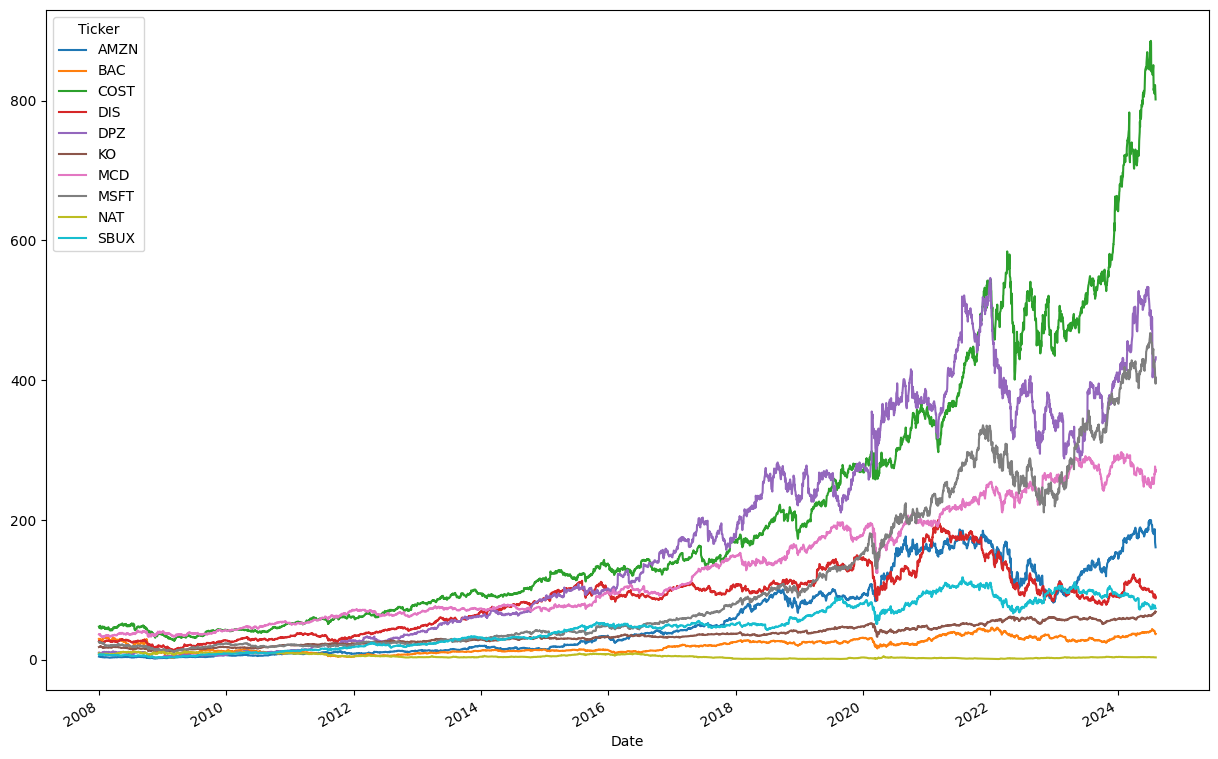

In [7]:
prices[prices.index >= "2008-01-01"].plot(figsize=(15,10));

Download SPY's prices

In [8]:
# SPY: SPDR S&P 500 ETF Trust. It is designed to track the S&P 500 stock market index. This fund is the largest and oldest ETF in the USA.
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


Date
1993-01-29    24.684103
1993-02-01    24.859659
1993-02-02    24.912333
1993-02-03    25.175663
1993-02-04    25.281013
Name: Adj Close, dtype: float64

<Axes: xlabel='Date'>

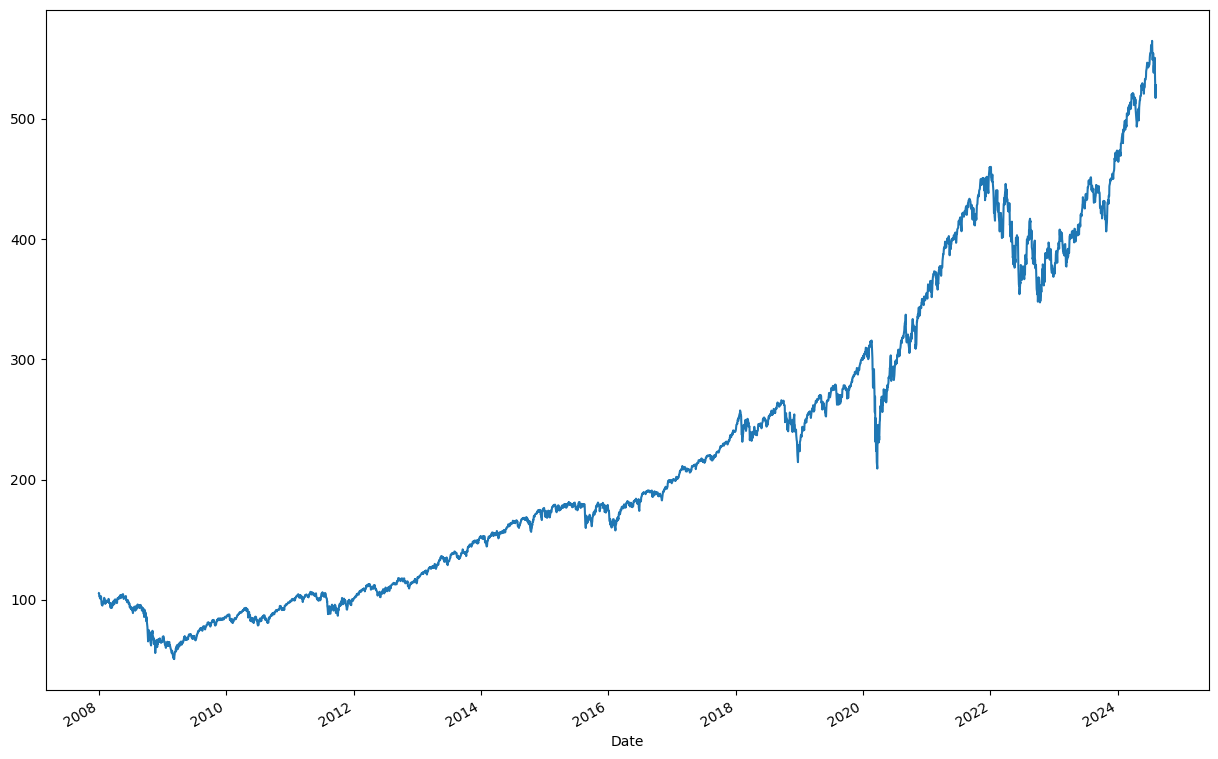

In [9]:
market_prices[market_prices.index >= "2008-01-01"].plot(figsize=(15,10))

In [10]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MSFT': 3000941150208,
 'AMZN': 1722957692928,
 'NAT': 728698048,
 'BAC': 288814694400,
 'DPZ': 15139549184,
 'DIS': 165165596672,
 'KO': 295484686336,
 'MCD': 195809296384,
 'COST': 368613130240,
 'SBUX': 85953216512}

## Constructing the prior

In [11]:
import pypfopt
pypfopt.__version__

'1.5.5'

In [12]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel #, plotting

# Covariance shrinkage: techniques that involve combining the sample covariance matrix with a structured estimator, to reduce the effect of erroneous weights.
#Ledoit Wolf shrinkage, which chooses an optimal shrinkage parameter. 
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf() # Covariance Matrix of asset returns
delta = black_litterman.market_implied_risk_aversion(market_prices) # Prior estimate of returns, calculated by the market’s excess return divided by its variance: (R-R_f)/sig^2
delta

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")


2.7178592896166798

If you think that the mean historical returns are a good prior, you could go with that. But a significant body of research shows that mean historical returns are a completely uninformative prior.

In [13]:
S

Ticker,AMZN,BAC,COST,DIS,DPZ,KO,MCD,MSFT,NAT,SBUX
Ticker,,,,,,,,,,
AMZN,0.137344,0.025835,0.020260,0.023493,0.013444,0.008255,0.011301,0.030899,0.013757,0.025993
BAC,0.025835,0.117339,0.021177,0.035438,0.015524,0.021424,0.023037,0.026852,0.022629,0.026677
COST,0.020260,0.021177,0.060245,0.018745,0.008376,0.012548,0.013666,0.022246,0.007651,0.017776
DIS,0.023493,0.035438,0.018745,0.099112,0.010328,0.025380,0.030484,0.025615,0.013215,0.020151
DPZ,0.013444,0.015524,0.008376,0.010328,0.040683,0.005201,0.007301,0.010345,0.009789,0.013758
KO,0.008255,0.021424,0.012548,0.025380,0.005201,0.052801,0.022853,0.016369,0.005884,0.011394
MCD,0.011301,0.023037,0.013666,0.030484,0.007301,0.022853,0.078851,0.015565,0.007226,0.014773
MSFT,0.030899,0.026852,0.022246,0.025615,0.010345,0.016369,0.015565,0.069091,0.011465,0.021137
NAT,0.013757,0.022629,0.007651,0.013215,0.009789,0.005884,0.007226,0.011465,0.091842,0.012999


(10.5, -0.5)

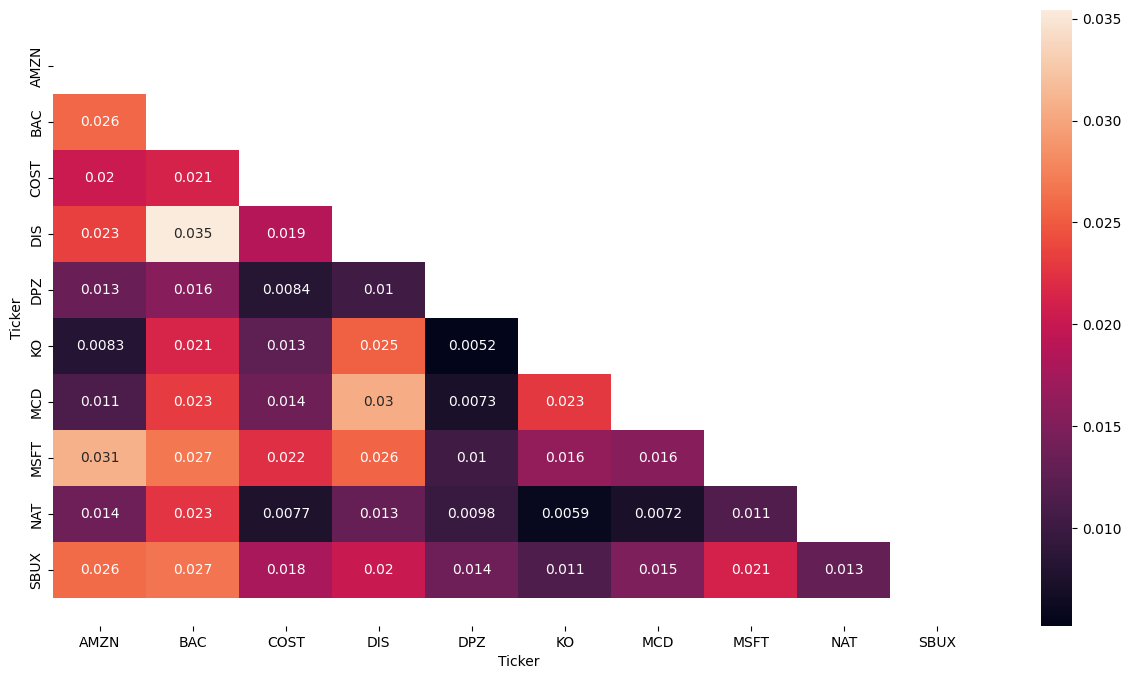

In [14]:
# Plot correlation matrix
# plotting.plot_covariance(S, plot_correlation=True); # Original code, but plotting has a bug. The scale is 0-1
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
mask = np.triu(np.ones_like(S, dtype=bool))
ax = sns.heatmap(data=S, annot=True, mask=mask)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [15]:
# This formula is calculating the total amount of risk contributed by an asset and multiplying it with the market price of risk, resulting in the market-implied returns vector Π
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)  
market_prior

Ticker
AMZN    0.177271
BAC     0.102350
COST    0.082475
DIS     0.093585
DPZ     0.050215
KO      0.064042
MCD     0.067138
MSFT    0.148655
NAT     0.052817
SBUX    0.081306
dtype: float64

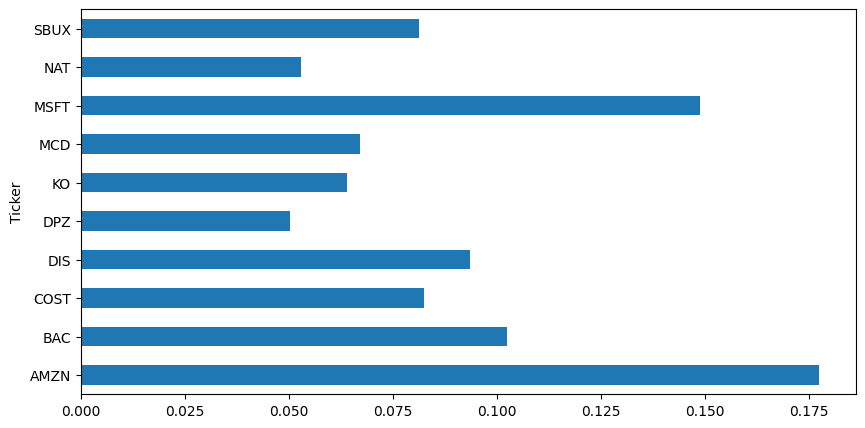

In [16]:
market_prior.plot.barh(figsize=(10,5));

## Views (This is the part we can use Sentiment Analysis to get more acurate views)

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

Absolute views are statements like: “AAPL will return 10%” or “XOM will drop 40%”. 

In [17]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

The confidence matrix(Omega) is a diagonal covariance matrix containing the variances of each view.

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [18]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [19]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

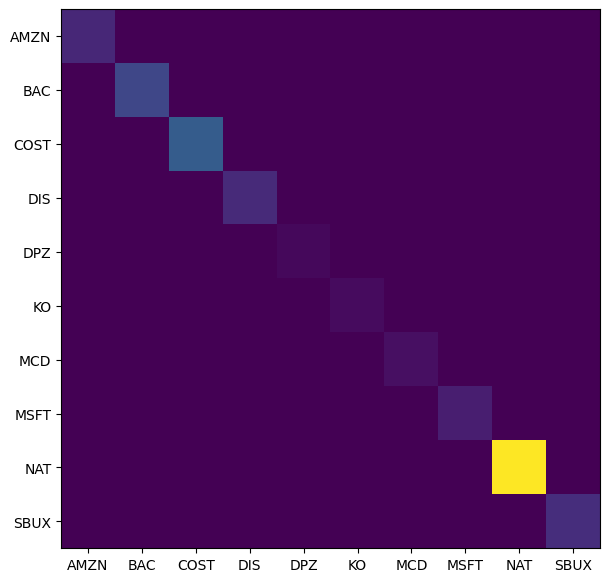

In [20]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [21]:
np.diag(bl.omega)

array([0.00457812, 0.00880039, 0.01204904, 0.00495561, 0.00087177,
       0.00113145, 0.00168967, 0.00345457, 0.04132879, 0.00541772])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [22]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [23]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates

The BL model outputs posterior estimates of the returns and covariance matrix. 

Given the inputs, we can compute a posterior estimate of returns


In [24]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [25]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

Ticker
AMZN    0.150702
BAC     0.129798
COST    0.063924
DIS     0.070688
DPZ     0.105326
KO      0.007706
MCD     0.102485
MSFT    0.104775
NAT     0.061261
SBUX    0.081720
dtype: float64

We can visualise how this compares to the prior and our views:

In [26]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.177271,0.150702,0.10
BAC,0.102350,0.129798,0.30
COST,0.082475,0.063924,0.05
DIS,0.093585,0.070688,0.05
DPZ,0.050215,0.105326,0.20
KO,0.064042,0.007706,-0.05
MCD,0.067138,0.102485,0.15
MSFT,0.148655,0.104775,0.10
NAT,0.052817,0.061261,0.50
SBUX,0.081306,0.081720,0.10


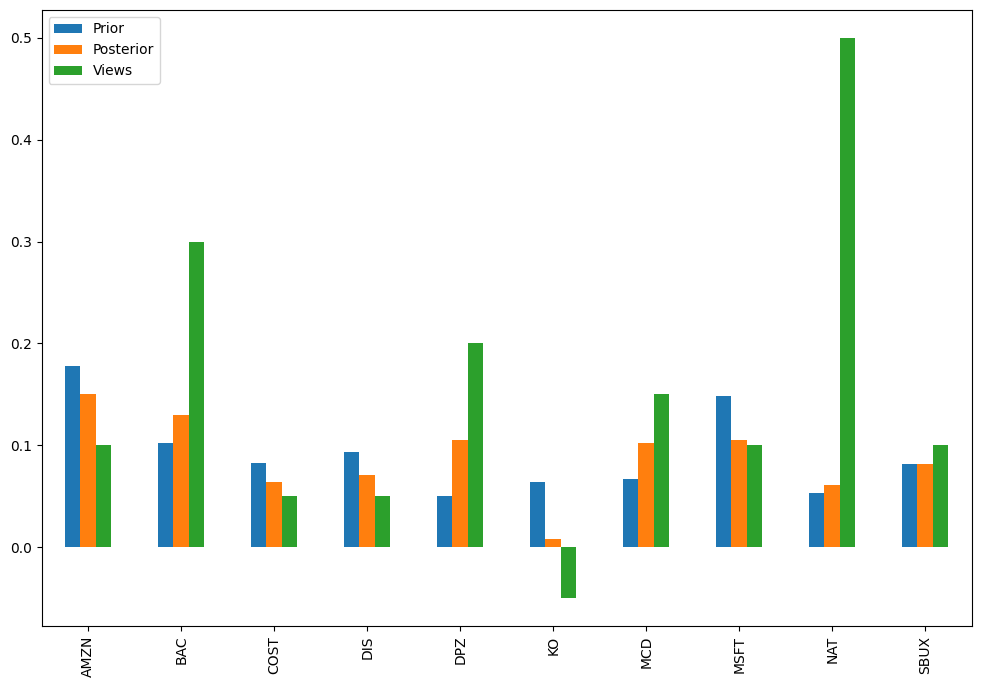

In [27]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

(10.5, -0.5)

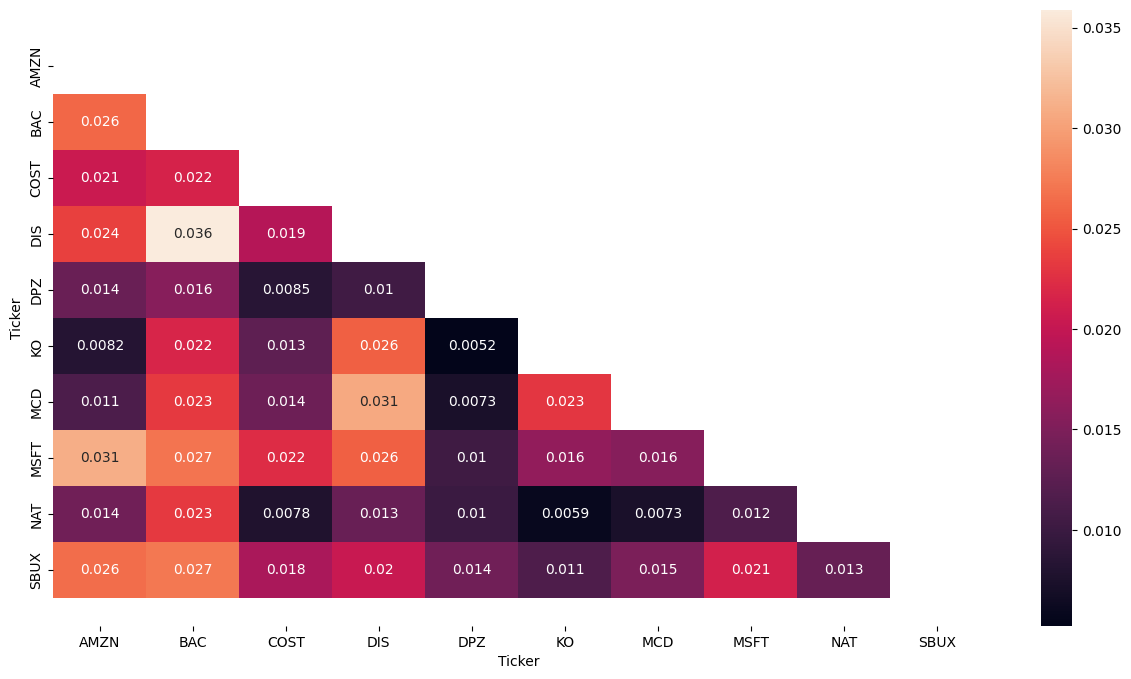

In [28]:
S_bl = bl.bl_cov()
# plotting.plot_covariance(S_bl);
plt.figure(figsize=(15,8))
mask = np.triu(np.ones_like(S_bl, dtype=bool))
ax = sns.heatmap(data=S_bl, annot=True, mask=mask)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [29]:
from pypfopt import EfficientFrontier, objective_functions

In [30]:
# Optimize for maximal Sharpe ratio
# Long/short: by default all of the mean-variance optimization methods in PyPortfolioOpt are long-only, but they can be initialised to allow for short positions by changing the weight bounds:ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AMZN', 0.19099),
             ('BAC', 0.15776),
             ('COST', 0.05915),
             ('DIS', 0.06254),
             ('DPZ', 0.13753),
             ('KO', 0.0),
             ('MCD', 0.12512),
             ('MSFT', 0.12488),
             ('NAT', 0.05631),
             ('SBUX', 0.08572)])


One issue with mean-variance optimization is that it leads to many zero-weights. While these are "optimal" in-sample, there is a large body of research showing that this characteristic leads mean-variance portfolios to underperform out-of-sample. 

Note: objective_functions.L2_reg it adds a penalty (parameterised by gamma) on small weights, with a term that looks just like L2 regularisation in machine learning. It can reduce the number of negligible weights for any of the objective functions.

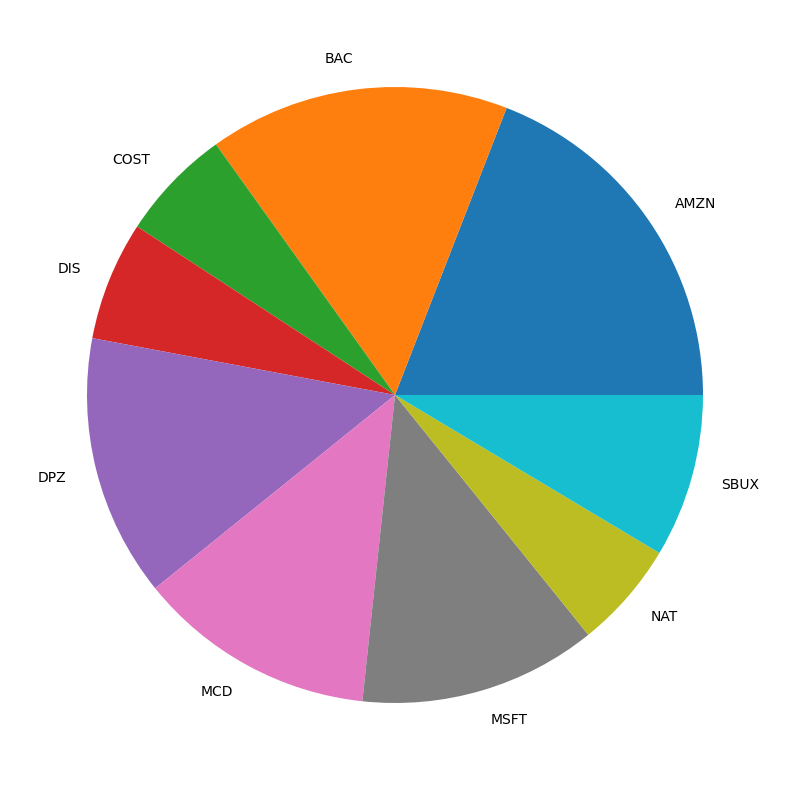

In [32]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [33]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

TypeError: latest_prices should be a pd.Series with no NaNs